In [1]:
#%pip install matplotlib

In [2]:
import os
import json

import torch

from core.schemas import Config

from scripts.generate import *

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

%matplotlib notebook

In [7]:
PROMPT = 'midnight reveries'

In [8]:
CONFIG_FILE = './configs/local.json'
DEVICE = torch.device(os.environ.get("DEVICE", 'cuda' if torch.cuda.is_available() else 'cpu'))

In [9]:
print(f"Loading configuration from '{CONFIG_FILE}'")
with open(CONFIG_FILE, 'r') as f:
    PARAMS = Config(**json.load(f))
PARAMS.prompts = [PROMPT]
print(f"Running on {DEVICE}.")
print(PARAMS)

global_seed(PARAMS.seed)

model = load_vqgan_model(PARAMS.vqgan_config, PARAMS.vqgan_checkpoint, PARAMS.models_dir).to(DEVICE)
perceptor = clip.load(PARAMS.clip_model, device=DEVICE, root=PARAMS.models_dir)[0].eval().requires_grad_(False).to(DEVICE)

cut_size = perceptor.visual.input_resolution
make_cutouts = MakeCutouts(PARAMS.augments, cut_size, PARAMS.cutn, cut_pow=PARAMS.cut_pow)

z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
z = initialize_image(model, PARAMS)
z_orig = torch.zeros_like(z)
z.requires_grad_(True)

prompts = tokenize(model, perceptor, make_cutouts, PARAMS)
optimizer = get_optimizer(z, PARAMS.optimizer, PARAMS.step_size)
scheduler = get_scheduler(optimizer, PARAMS.max_iterations, PARAMS.nwarm_restarts)

kwargs = {
    'model': model,
    'perceptor': perceptor,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'prompts': prompts,
    'make_cutouts': make_cutouts,
    'z_orig': z_orig,
    'z_min': z_min,
    'z_max': z_max,
    'mse_weight': PARAMS.init_weight,
}




Loading configuration from './configs/local.json'
Saving outputs in './outputs'
Running on cuda.
Config:
  - prompts: ['midnight reveries']
  - image_prompts: []
  - max_iterations: 250
  - save_freq: 50
  - size: [256, 256]
  - pixelart: None
  - init_image: 
  - init_noise: 
  - init_weight: 0.0
  - mse_decay_rate: 0
  - output_dir: ./outputs
  - models_dir: ./models
  - clip_model: ViT-B/16
  - vqgan_checkpoint: ./models/vqgan_imagenet_f16_16384.ckpt
  - vqgan_config: ./configs/models/vqgan_imagenet_f16_16384.json
  - noise_prompt_seeds: []
  - noise_prompt_weights: []
  - step_size: 0.1
  - cutn: 32
  - cut_pow: 1.0
  - seed: -1
  - optimizer: Adam
  - nwarm_restarts: -1
  - augments: ['Af', 'Pe', 'Ji', 'Er']

Global seed set to 4114189190.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Loaded pretrained VGG16 model from './models/vgg16-397923af.pth'
Loaded pretrained LPIPS loss from './models/vgg.pth'
VQLPIPSWithDiscriminator running with hinge loss.
Restored from ./

<IPython.core.display.Javascript object>


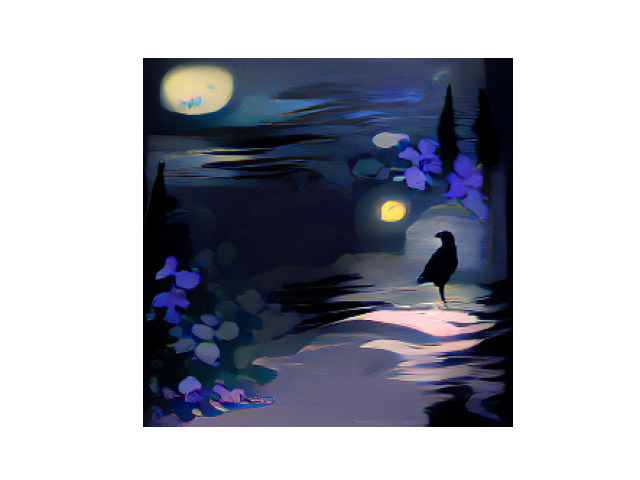

step: 50, loss: 0.810844, losses: 0.810844
step: 100, loss: 0.794331, losses: 0.794331
step: 150, loss: 0.77556, losses: 0.77556
step: 200, loss: 0.771838, losses: 0.771838
step: 250, loss: 0.767731, losses: 0.767731



In [10]:
fig,ax = plt.subplots(1,1)

for step in tqdm(range(PARAMS.max_iterations)):
    kwargs['step'] = step + 1
    pil_image = train(z, PARAMS, **kwargs)
    if step % 5 == 0:
        ax.imshow(np.asarray(pil_image))
        plt.axis('off')
        fig.canvas.draw()
